# Lista 6

In [1]:
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.stats import poisson
import numpy as np, matplotlib.pyplot as plt

## zadanie 1
#### metoda przerzedzania

Napisz algorytm, który dla ustalonej niejednorodnej funkcji intensywności λ(t) generuje czasy oczekiwania niejednorodnego procesu Poissona metodą przerzedzania.
Sprawdź poprawność jego działania weryfikując, że $N_t ∼ Poiss(\int_0^t \lambda(s) \operatorname{d}\!s)$.


In [2]:
def lambda1(x):
    return np.sin(x)**2

In [11]:
def poiss_thinning(lambd, T):
    t = 0 
    I = 0
    S = []

    max_lam = max(lambd(t) for t in np.linspace(0, T, 1000))

    while t < T:
        u1 = np.random.rand()
        t += -np.log(u1) / max_lam

        u2 = np.random.rand()

        if u2 <= lambd(t) / max_lam:
            I += 1
            S.append(t)

    return S

In [4]:
def t4(t):
    return t**4

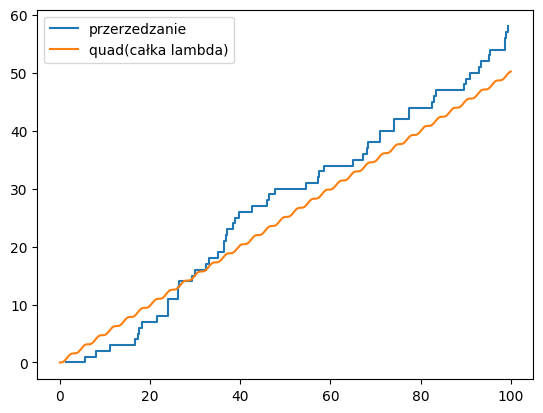

In [34]:
T = 100
points = poiss_thinning(lambda1, T)
times = np.linspace(0,T, 1000)
plt.step(points, range(len(points)), where='post', label = 'przerzedzanie')
y = [quad(lambda1, 0, t)[0] for t in times]
plt.plot(times, y, label = 'quad(całka lambda)')
plt.legend()
plt.show()

## zadanie 2
#### metoda odwrotnej dystrybuanty

Dla przypadków, w których możemy łatwo wyznaczać $m(t) = \int_0^t λ(s) \operatorname{d}\!s$ można użyć
alternatywnego algorytmu.
- Dla ustalonego T wygenerować zmienną $N_T$ ∼ Poiss($m(T)$).
- Za czasy oczekiwania wziąć $N_T$ posortowanych zmiennych o dystrybuancie: \
$F(t) = \frac{m(t)}{m(T)}$
.
Sprawdź również jego działanie.


In [27]:
def m(t, lambd):
    x, _ = quad(lambd,0,t)
    return x

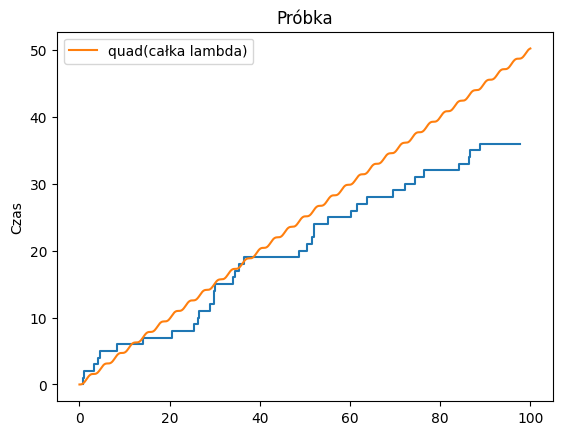

In [49]:
def F(t, m, T):
    return m(t)/m(T)

def times_poiss(lambd, T, n):
    m_T = m(T, lambd)
    NT = np.random.poisson(m_T) 
    times = np.linspace(0, T, n)
    ms = [m(t, lambd)/m_T for t in times]
    F_inv = interp1d(ms, times, fill_value='extrapolate')
    sorted_waiting_times = np.sort([F_inv(u) for u in np.random.rand(NT)])
    
    return sorted_waiting_times

T = 100 
n = 60
tims = times_poiss(lambda1, T, n)
times = np.linspace(0,T, 1000)
plt.step(tims, range(len(tims)))
y = [m(t, lambda1) for t in times]
plt.plot(times, y, label = 'quad(całka lambda)')
plt.ylabel('Czas')
plt.title('Próbka')
plt.legend()
plt.show()


## zadanie 3
#### łączenie procesów Poissona
Mając 2 niezależne niejednorodne procesy Poissona stwórz proces składający się z
połączenia wszystkich zdarzeń obu. Sprawdź, że jego intensywność jest sumą 2 oryginalnych intensywności.


Text(0, 0.5, 'Średnia liczba zdarzeń')

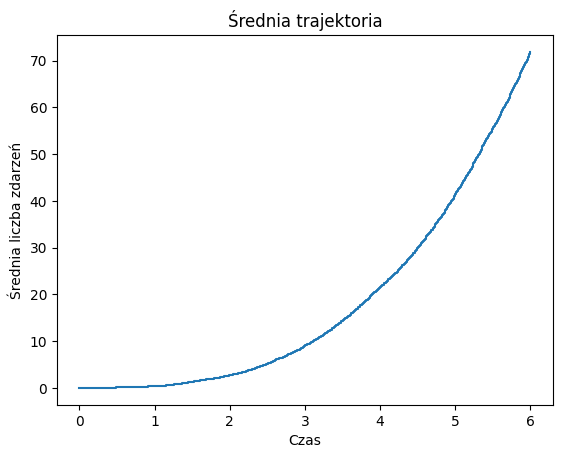

In [ ]:
def inh_poiss(lambd, T, n, nn):
    times = np.linspace(0, T, n)
    ms = [quad(lambd,0,t)[0] for t in times]
    T_tilde = ms[-1]
    m_inv = interp1d(ms, times, fill_value='extrapolate')

    t = 0
    I = 0
    S = []

    while True:
        U = np.random.uniform()
        t += -np.log(U)
        if t > T_tilde:
            break
        I += 1
        S.append(m_inv(t))

    full_time = np.linspace(0,T, nn)
    full_trajectory = np.zeros_like(full_time)

    for jump_time in S:
        full_trajectory[full_time >= jump_time] += 1

    return S, full_trajectory, full_time

def lam1(t):
    return t**2

def lam2(t):
    return t**4

T = 6
n = 100
nn = 500
full_time = np.linspace(0,T, nn)
tr = np.array([inh_poiss(lam1, T, n, nn)[1] for _ in range(n)])
avt = np.mean(tr, axis = 0)
plt.step(full_time, avt, where='post')
plt.title('Średnia trajektoria')
plt.xlabel('Czas')
plt.ylabel('Średnia liczba zdarzeń')

In [ ]:
S1, tr1, t1 = inh_poiss(lam1, T, n, nn)
S2, tr2, t2 = inh_poiss(lam1, T, n, nn)

combined_t = np.sort(np.concatenate((S1,S2)))
tr3 = np.zeros_like(full_time)
for jump in combined_t:
    tr3[full_time >= jump] += 1
    

Text(0, 0.5, 'Liczba zdarzeń')

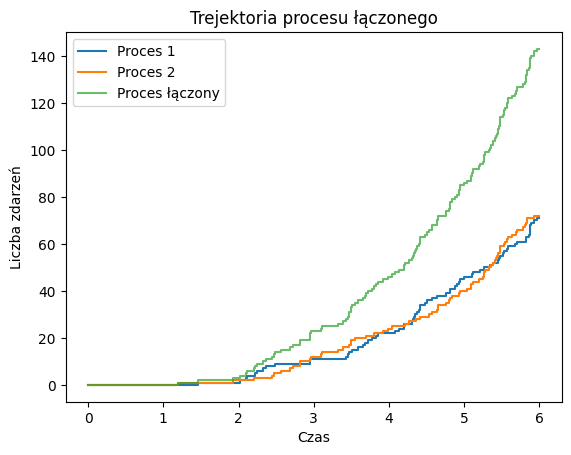

In [ ]:
plt.step(t1, tr1, where='post', label = 'Proces 1')
plt.step(t2, tr2, where='post', label = 'Proces 2')
plt.step(full_time, tr3, where='post', label = 'Proces łączony', alpha = 0.7)
plt.legend()
plt.title('Trejektoria procesu łączonego')
plt.xlabel('Czas')
plt.ylabel('Liczba zdarzeń')

## zadanie 4
#### złożony proces Poissona
Napisz funkcję, która jako argumenty będzie przyjmowała $T > 0$ (horyzont czasowy)
oraz dystrybuantę $F_Z$ zmiennych Z i będzie zwracała trajektorie złożonego procesu
Poissona $Y_t$. W jaki sposób najlepiej reprezentować te trajektorie?


In [56]:
def poisson_process(T, FZ, n=1000):
    times = np.linspace(0, T, n)

    Yt = np.zeros_like(times)
    for i in range(1, len(times)):
        dt = times[i] - times[i - 1]
        lambda_t = FZ(np.random.uniform(0, T))
        Yt[i] = Yt[i - 1] + np.random.poisson(lambda_t * dt)

    return times, Yt


def FZ(z):
    return  z**4

Text(0, 0.5, 'Wartości procesu')

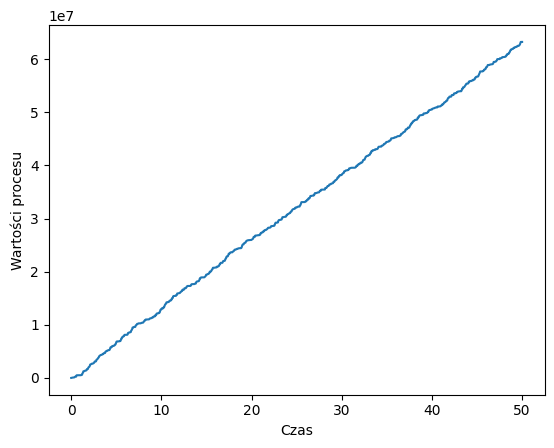

In [57]:
T = 50  
t_values, Yt = poisson_process(T, FZ)
plt.plot(t_values, Yt)
plt.xlabel('Czas')
plt.ylabel('Wartości procesu')